# Time Series Analysis

| Information | Details |
|----------|---------|
| Learning Objectives | • Work with datetime data in pandas<br>• Apply time series operations to power system data<br>• Identify daily and weekly load patterns<br>• Implement basic forecasting methods<br>• Decompose time series into components |
| Prerequisites | Python fundamentals, NumPy basics, Pandas data manipulation |
| Estimated Time | 2 hours |
| Topics | Datetime indexing, resampling, rolling windows, pattern analysis, simple forecasting, decomposition |

## Introduction

Time series analysis is fundamental to power system operations. System operators analyze historical load patterns to forecast future demand, schedule generation resources, and ensure grid stability. This lesson teaches practical time series techniques specifically for power system data.

Power systems exhibit strong temporal patterns driven by human behavior and weather conditions. Morning load increases as people wake up and businesses open. Evening peaks occur when residential cooling and lighting demands coincide. Weekends show different patterns than weekdays. Understanding and forecasting these patterns is crucial for reliable and economic grid operation.

We'll start with pandas datetime functionality, then progress through pattern identification to basic forecasting. All examples use realistic power system data scales and patterns you'll encounter in practice.

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_rows', 10)
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)  # For reproducibility

## Working with Datetime Data

Power system data is inherently temporal. Measurements are recorded at specific times, and the timestamp is as important as the value itself. Pandas provides powerful tools for working with datetime data through its DatetimeIndex.

### Creating Time Series Data

In [2]:
# Create a week of hourly timestamps
dates = pd.date_range(start='2024-01-01', 
                     end='2024-01-07 23:00:00', 
                     freq='h')
print(f"Created {len(dates)} hourly timestamps")
print(f"First: {dates[0]}")
print(f"Last: {dates[-1]}")

Created 168 hourly timestamps
First: 2024-01-01 00:00:00
Last: 2024-01-07 23:00:00


In [3]:
# Generate simple load data with daily pattern
hours = np.arange(len(dates))
daily_pattern = 100 * np.sin((hours % 24) * 2 * np.pi / 24 - np.pi/2) + 500
noise = np.random.normal(0, 10, len(dates))
load = daily_pattern + noise

# Create DataFrame
df = pd.DataFrame({
    'load': load
}, index=dates)

df.head()

,load
2024-01-01 00:00:00,404.967142
2024-01-01 01:00:00,402.024774
2024-01-01 02:00:00,419.874345
2024-01-01 03:00:00,444.519620
2024-01-01 04:00:00,447.658466


### Accessing Datetime Components

The DatetimeIndex provides easy access to datetime components, which is essential for analyzing patterns and creating features for forecasting models.

In [4]:
# Extract datetime components
df['hour'] = df.index.hour
df['day_of_week'] = df.index.day_name()
df['date'] = df.index.date

# Show a few rows
df[['load', 'hour', 'day_of_week']].head()

,load,hour,day_of_week
2024-01-01 00:00:00,404.967142,0,Monday
2024-01-01 01:00:00,402.024774,1,Monday
2024-01-01 02:00:00,419.874345,2,Monday
2024-01-01 03:00:00,444.519620,3,Monday
2024-01-01 04:00:00,447.658466,4,Monday


```{admonition} Tip: Datetime Indexing
:class: tip
With a DatetimeIndex, you can slice data using string dates: `df['2024-01-03']` gets all data for January 3rd, and `df['2024-01-03':'2024-01-04']` gets a range.
```

In [5]:
# Select specific time periods
jan_3 = df.loc['2024-01-03']
print(f"January 3rd has {len(jan_3)} hours of data")
print(f"Peak load: {jan_3['load'].max():.1f} MW at hour {jan_3['load'].idxmax().hour}")

January 3rd has 24 hours of data
Peak load: 606.3 MW at hour 11


## Basic Time Series Operations

Power system analysis frequently requires aggregating high-frequency data and calculating moving statistics. These operations help identify trends and smooth out noise in measurements.

### Resampling: Changing Time Frequency

In [6]:
# Resample hourly to daily
daily = df['load'].resample('D').agg({
    'mean': 'mean',
    'max': 'max',
    'min': 'min'
})

daily

,mean,max,min
2024-01-01,498.523617,602.419623,389.159936
2024-01-02,497.370436,602.088636,394.556173
2024-01-03,500.968273,606.348034,385.777016
2024-01-04,498.674194,601.381481,387.200009
2024-01-05,500.505028,605.464399,402.961203
2024-01-06,499.103347,601.328507,394.313543
2024-01-07,502.117208,618.657745,401.027953


```{admonition} Important: Resampling Rules
:class: important
Common frequency codes: 'h' (hourly), 'D' (daily), 'W' (weekly), 'M' (monthly). Always specify an aggregation method (mean, sum, max, etc.) when downsampling.
```

### Rolling Windows and Moving Averages

Moving averages smooth out short-term fluctuations and highlight longer-term trends. They're fundamental to many forecasting methods.

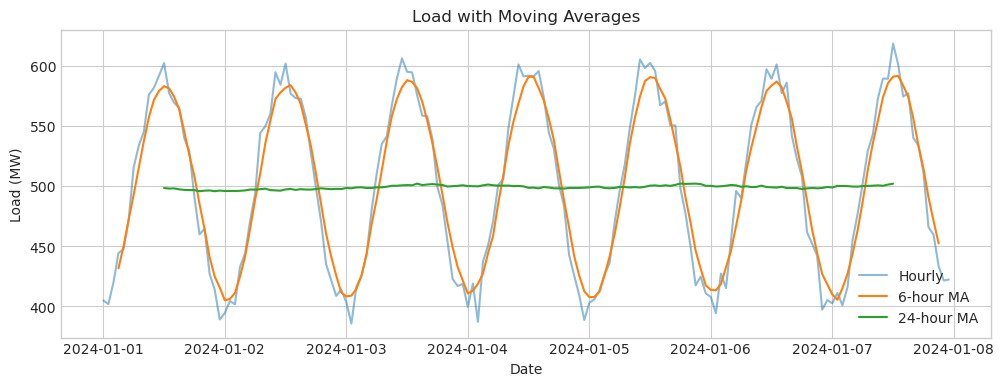

In [7]:
# Calculate rolling statistics
df['ma_6h'] = df['load'].rolling(window=6, center=True).mean()
df['ma_24h'] = df['load'].rolling(window=24, center=True).mean()

# Plot original vs smoothed
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['load'], alpha=0.5, label='Hourly')
plt.plot(df.index, df['ma_6h'], label='6-hour MA')
plt.plot(df.index, df['ma_24h'], label='24-hour MA')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.title('Load with Moving Averages')
plt.legend()
plt.show()

### Calculating Changes and Growth Rates

In [8]:
# Calculate hour-to-hour changes
df['change'] = df['load'].diff()
df['pct_change'] = df['load'].pct_change() * 100

# Find largest changes
max_increase = df['change'].max()
max_decrease = df['change'].min()
print(f"Max hourly increase: {max_increase:.1f} MW")
print(f"Max hourly decrease: {max_decrease:.1f} MW")

Max hourly increase: 50.4 MW
Max hourly decrease: -52.4 MW


## Identifying Load Patterns

Power system loads follow predictable patterns. Daily patterns reflect human activity cycles, while weekly patterns show the difference between weekdays and weekends. Identifying these patterns is the first step toward accurate forecasting.

### Daily Load Profiles

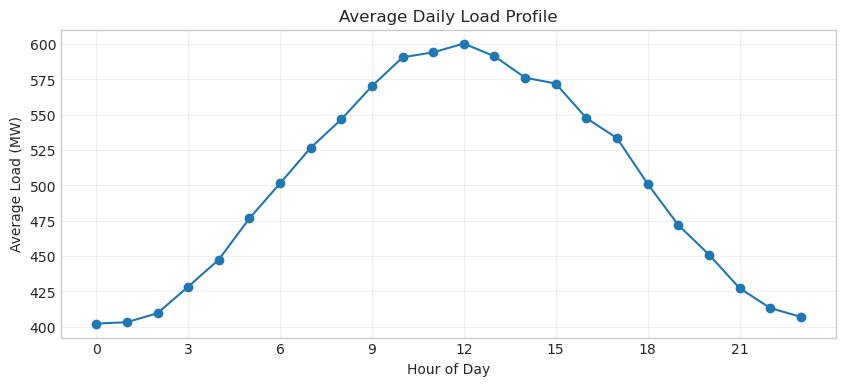

In [9]:
# Calculate average hourly profile
hourly_profile = df.groupby('hour')['load'].mean()

plt.figure(figsize=(10, 4))
plt.plot(hourly_profile.index, hourly_profile.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Load (MW)')
plt.title('Average Daily Load Profile')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 3))
plt.show()

```{admonition} Tip: Peak Hours
:class: tip
Most power systems see morning peaks (6-9 AM) and evening peaks (5-8 PM). The evening peak is typically higher due to combined residential and commercial loads.
```

In [10]:
# Identify peak hours
peak_hour = hourly_profile.idxmax()
min_hour = hourly_profile.idxmin()
print(f"Peak typically at hour {peak_hour} ({peak_hour}:00)")
print(f"Minimum typically at hour {min_hour} ({min_hour}:00)")

Peak typically at hour 12 (12:00)
Minimum typically at hour 0 (0:00)


### Weekly Patterns

Weekday and weekend loads differ significantly. Industrial and commercial loads drop on weekends, while residential patterns change due to different wake and activity times.

In [11]:
# Create more data for weekly analysis
dates_month = pd.date_range(start='2024-01-01', periods=30*24, freq='h')
hours_month = np.arange(len(dates_month))

# Add weekly pattern (lower on weekends)
daily_base = 100 * np.sin((hours_month % 24) * 2 * np.pi / 24 - np.pi/2) + 500
weekend_factor = np.where(dates_month.weekday >= 5, 0.8, 1.0)
load_month = daily_base * weekend_factor + np.random.normal(0, 10, len(dates_month))

df_month = pd.DataFrame({'load': load_month}, index=dates_month)
df_month['is_weekend'] = df_month.index.weekday >= 5

In [12]:
# Compare weekday vs weekend
weekday_avg = df_month[~df_month['is_weekend']]['load'].mean()
weekend_avg = df_month[df_month['is_weekend']]['load'].mean()

print(f"Average weekday load: {weekday_avg:.1f} MW")
print(f"Average weekend load: {weekend_avg:.1f} MW")
print(f"Weekend reduction: {(1 - weekend_avg/weekday_avg)*100:.1f}%")

Average weekday load: 500.2 MW
Average weekend load: 400.3 MW
Weekend reduction: 20.0%


## Simple Forecasting Methods

Before applying complex models, it's important to establish baseline forecasts using simple methods. These baselines help evaluate whether more sophisticated approaches actually improve accuracy.

### Naive Forecast: Using Yesterday's Value

The simplest forecast assumes tomorrow will be like today. For power systems, we typically use "yesterday same hour" as the naive forecast.

In [13]:
# Create train and test sets
train = df_month['2024-01-01':'2024-01-21']
test = df_month['2024-01-22':'2024-01-24']

# Naive forecast: use same hour from previous day
naive_forecast = train['load'].shift(24).iloc[-len(test):]
naive_forecast.index = test.index

In [14]:
# Calculate error metrics
mae = np.mean(np.abs(test['load'] - naive_forecast))
mape = np.mean(np.abs((test['load'] - naive_forecast) / test['load'])) * 100

print(f"Naive Forecast Performance:")
print(f"MAE: {mae:.2f} MW")
print(f"MAPE: {mape:.2f}%")

Naive Forecast Performance:
MAE: 40.55 MW
MAPE: 8.11%


```{admonition} Important: Forecast Metrics
:class: important
MAE (Mean Absolute Error) measures average error in MW. MAPE (Mean Absolute Percentage Error) measures relative error. MAPE is useful for comparing accuracy across different load levels.
```

### Moving Average Forecast

Moving averages smooth out random fluctuations and can provide better forecasts than naive methods when there's high volatility.

In [15]:
# Create moving average forecast
window = 24  # Use last 24 hours
ma_forecast = train['load'].rolling(window=window).mean().iloc[-1]

# For simplicity, use constant forecast
ma_forecast_series = pd.Series([ma_forecast] * len(test), index=test.index)

### Similar Day Forecast

Power systems show strong weekly patterns. Using the same day from the previous week often provides good forecasts.

In [16]:
# Similar day: same hour from same day last week
similar_day_forecast = train['load'].shift(7*24).iloc[-len(test):]
similar_day_forecast.index = test.index

# Calculate performance
mae_similar = np.mean(np.abs(test['load'] - similar_day_forecast))
print(f"Similar Day MAE: {mae_similar:.2f} MW")

Similar Day MAE: 69.42 MW


### Comparing Forecast Methods

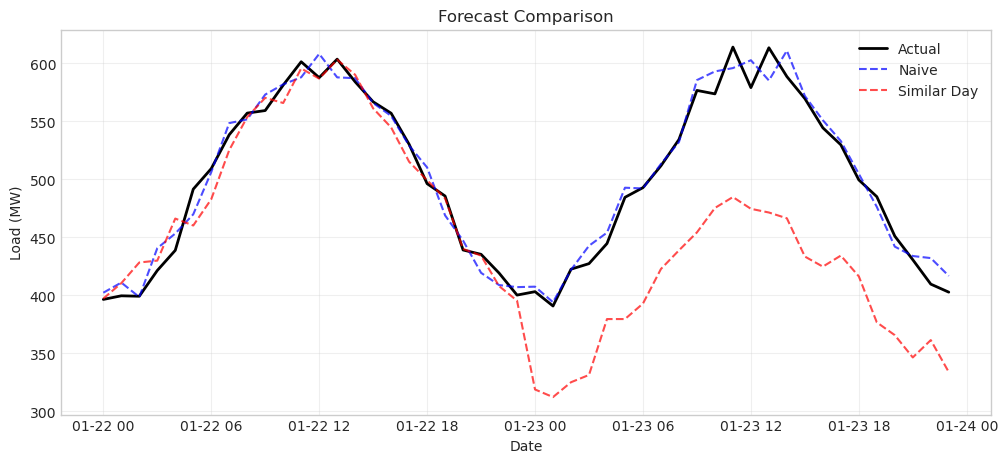

In [17]:
# Plot first 48 hours of test period
plot_hours = 48
plt.figure(figsize=(12, 5))
plt.plot(test.index[:plot_hours], test['load'][:plot_hours], 
         'k-', label='Actual', linewidth=2)
plt.plot(test.index[:plot_hours], naive_forecast[:plot_hours], 
         'b--', label='Naive', alpha=0.7)
plt.plot(test.index[:plot_hours], similar_day_forecast[:plot_hours], 
         'r--', label='Similar Day', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.title('Forecast Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Time Series Decomposition

Decomposition separates a time series into trend, seasonal, and residual components. This helps understand the underlying structure and can improve forecasting by modeling each component separately.

In [18]:
!pip install statsmodels

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose one week of data
week_data = df['2024-01-01':'2024-01-07']['load']
decomposition = seasonal_decompose(week_data, model='additive', period=24)

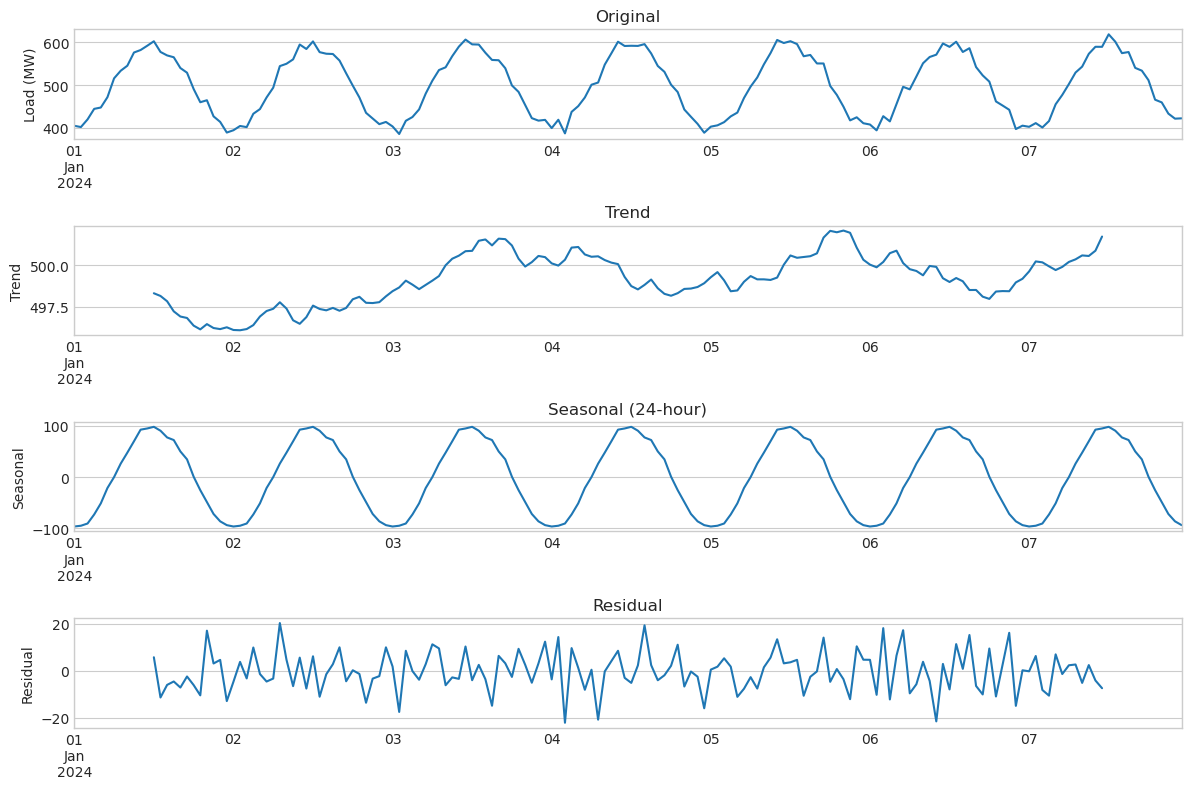

In [20]:
# Plot components
fig, axes = plt.subplots(4, 1, figsize=(12, 8))

week_data.plot(ax=axes[0], title='Original')
axes[0].set_ylabel('Load (MW)')

decomposition.trend.plot(ax=axes[1], title='Trend')
axes[1].set_ylabel('Trend')

decomposition.seasonal.plot(ax=axes[2], title='Seasonal (24-hour)')
axes[2].set_ylabel('Seasonal')

decomposition.resid.plot(ax=axes[3], title='Residual')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

```{admonition} Warning: Decomposition Assumptions
:class: warning
Additive decomposition assumes seasonal fluctuations are constant over time. Use multiplicative decomposition if seasonal patterns scale with the level of the time series.
```

### Exercise 1: Daily Peak Detection

Power system operators need to know when daily peaks occur to schedule generation resources. In this exercise, you'll analyze a week of load data to find the daily peak loads and their timing.

Using the provided week of hourly load data, find the peak load and peak hour for each day. Calculate the average peak load across the week and identify which day had the highest peak. Also determine what hour of the day most commonly experiences the peak load.

```{admonition} Hint
:class: hint
Use `groupby` with the date to analyze each day separately. The `idxmax()` method returns the index (timestamp) of the maximum value, from which you can extract the hour.
```

In [21]:
# Exercise 1: Your code here
# Data for the exercise
exercise_data = df['2024-01-01':'2024-01-07']['load']

# Find daily peaks and their timing
# Your solution:

In [22]:
# Solution
# Group by date and find max
daily_peaks = exercise_data.groupby(exercise_data.index.date).agg(['max', 'idxmax'])

# Extract peak hours
daily_peaks['peak_hour'] = daily_peaks['idxmax'].dt.hour

# Display results
print("Daily Peak Analysis:")
print(daily_peaks[['max', 'peak_hour']])
print(f"\nAverage peak load: {daily_peaks['max'].mean():.1f} MW")
print(f"Highest peak: {daily_peaks['max'].max():.1f} MW on {daily_peaks['max'].idxmax()}")
print(f"Most common peak hour: {daily_peaks['peak_hour'].mode()[0]}:00")

Daily Peak Analysis:
                   max  peak_hour
2024-01-01  602.419623         12
2024-01-02  602.088636         12
2024-01-03  606.348034         11
2024-01-04  601.381481         10
2024-01-05  605.464399         10
2024-01-06  601.328507         13
2024-01-07  618.657745         12

Average peak load: 605.4 MW
Highest peak: 618.7 MW on 2024-01-07
Most common peak hour: 12:00


### Exercise 2: Simple Load Forecast

Accurate load forecasting is essential for power system operations. In this exercise, you'll implement and evaluate a simple 24-hour ahead forecast using a moving average approach.

Create a forecast for January 8th using the previous 7 days of data (January 1-7). Use a 24-hour moving average of the same hours from previous days. For example, to forecast 10 AM on January 8th, average the 10 AM values from January 1-7. Calculate the MAE and MAPE for your forecast. Compare your results to a naive forecast that simply uses January 7th's values.

```{admonition} Hint
:class: hint
Group the historical data by hour of day, then calculate the mean for each hour. This gives you an average profile that can be used as your forecast for the next day.
```

In [23]:
# Exercise 2: Your code here
# Historical data (7 days)
historical = df['2024-01-01':'2024-01-07']['load']

# Actual data for January 8th (to evaluate forecast)
dates_jan8 = pd.date_range(start='2024-01-08', periods=24, freq='h')
# Generate actual values for testing
np.random.seed(42)
hours_jan8 = np.arange(24) + 7*24  # Hours since start
actual_jan8 = 100 * np.sin((hours_jan8 % 24) * 2 * np.pi / 24 - np.pi/2) + 500
actual_jan8 += np.random.normal(0, 10, 24)
actual = pd.Series(actual_jan8, index=dates_jan8)

# Create your forecast here:
# Your solution:

Forecast Performance:
Moving Average - MAE: 7.14 MW, MAPE: 1.47%
Naive - MAE: 10.25 MW, MAPE: 2.16%


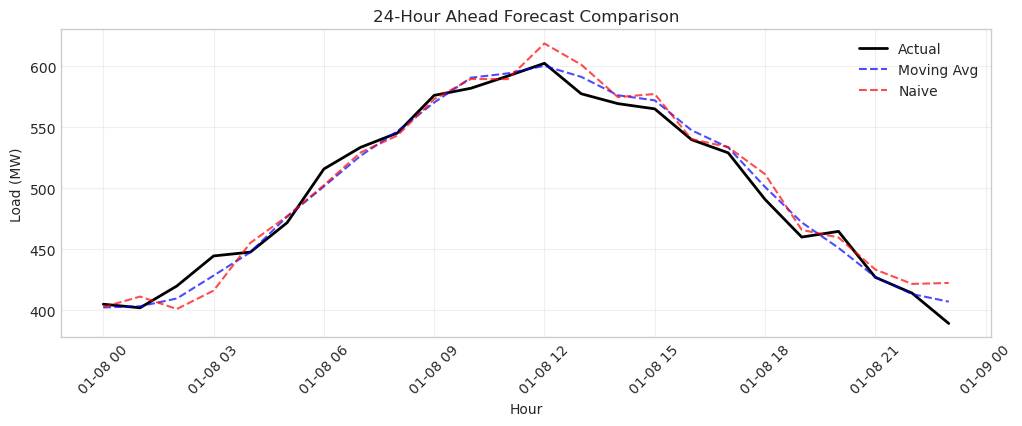

In [24]:
# Solution
# Method 1: Average by hour
hourly_avg = historical.groupby(historical.index.hour).mean()
forecast = pd.Series(hourly_avg.values, index=actual.index)

# Method 2: Naive (use January 7th)
jan7_data = df.loc['2024-01-07']['load']
naive = pd.Series(jan7_data.values, index=actual.index)

# Calculate errors
mae_forecast = np.mean(np.abs(actual - forecast))
mape_forecast = np.mean(np.abs((actual - forecast) / actual)) * 100

mae_naive = np.mean(np.abs(actual - naive))
mape_naive = np.mean(np.abs((actual - naive) / actual)) * 100

print("Forecast Performance:")
print(f"Moving Average - MAE: {mae_forecast:.2f} MW, MAPE: {mape_forecast:.2f}%")
print(f"Naive - MAE: {mae_naive:.2f} MW, MAPE: {mape_naive:.2f}%")

# Visualize
plt.figure(figsize=(12, 4))
plt.plot(actual.index, actual.values, 'k-', label='Actual', linewidth=2)
plt.plot(forecast.index, forecast.values, 'b--', label='Moving Avg', alpha=0.7)
plt.plot(naive.index, naive.values, 'r--', label='Naive', alpha=0.7)
plt.xlabel('Hour')
plt.ylabel('Load (MW)')
plt.title('24-Hour Ahead Forecast Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

## Summary

This lesson covered essential time series techniques for power system analysis. You learned to work with datetime data in pandas, identify load patterns, and implement basic forecasting methods. Time series decomposition revealed how loads combine trend, seasonal, and random components.

The simple forecasting methods we explored often perform surprisingly well for stable power systems. Moving averages smooth volatility, while similar-day approaches leverage weekly patterns. These techniques form the foundation for more advanced methods like ARIMA and machine learning models.

Power system operators use these techniques daily to forecast loads, schedule generation, and ensure reliable electricity supply. As renewable energy increases, accurate forecasting becomes even more critical for managing variable generation and maintaining grid stability.